## Combining two datasets. Using geosocial media data to understand retail performance

Geosocial data is location-based social media data that can be interpreted and analyzed as part of any location-oriented business decision. 

In this notebook, [Spatial.ai geosocial data](https://carto.com/spatial-data-catalog/browser/?provider=spatial_ai) is combined with [Mastercard financial data](https://carto.com/spatial-data-catalog/browser/?provider=mastercard) to quantify how much of retail performance can be explained by geosocial behavior. We compare the cities of Chicago and Los Angeles to show how retail performance is driven by different social segments depending on the city.

**Note** this use case leverages premium datasets from [CARTO Data Observatory](https://carto.com/spatial-data-catalog/).

The notebook is organized in the following sections:
1. [Download data from the Data Observatory](#section1)
2. [Analyzing geosocial drivers](#section2)
  - [Identify where top performers are](#section21)
  - [Characterization of top performers](#section22)
  - [Correlation analysis](#section23)

### 0. Setup

#### 0.1. Import packages

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from cartoframes.auth import set_default_credentials
from cartoframes.data.observatory import *
from cartoframes.viz import *
from shapely import wkt

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

%matplotlib inline

#### 0.2. Set CARTO default credentials

In order to be able to use the Data Observatory via CARTOframes, you need to set your CARTO account credentials first.

Please, visit the [Authentication guide](https://carto.com/developers/cartoframes/guides/Authentication/) for further detail.

In [2]:
from cartoframes.auth import set_default_credentials

set_default_credentials('creds.json')

**Note about credentials**

For security reasons, we recommend storing your credentials in an external file to prevent publishing them by accident when sharing your notebooks. You can get more information in the section _Setting your credentials_ of the [Authentication guide](https://carto.com/developers/cartoframes/guides/Authentication/).

<a id='section1'></a>
### 1. Download data from the Data Observatory

In this section, we'll download the two datasets we're interested in and combine them into a single dataframe.

For more information on how to access Data Observatory datasets using CARTOframes visit the [Guides](https://carto.com/developers/cartoframes/guides/) or take a look at the <a href='https://carto.com/developers/cartoframes/examples/#example-access-premium-data' target='_blank'>Access Premium Data</a> template.

#### Data loading functions

The following function loads the census block group ids for the city of interest. This is used afterwards to filter the data downloaded from the Data Observatory.

In [3]:
LA_CBG_PATH = 'https://libs.cartocdn.com/cartoframes/samples/la_cbg.csv'
LA_BB = '-118.673619,33.553967,-117.997960,34.360425'
CHICACO_CBG_PATH = 'https://libs.cartocdn.com/cartoframes/samples/chicago_cbg.csv'
CHICAGO_BB = '-88.638285,41.434892,-87.487468,42.502873'

def read_cbg(city):
    cbg_list = pd.DataFrame()
    bbox = ''
    if city == 'la':
        cbg_list = pd.read_csv(LA_CBG_PATH, dtype={'geoid':str})['geoid'].tolist()
        bbox = LA_BB
    elif city == 'chicago':
        cbg_list = pd.read_csv(CHICACO_CBG_PATH, dtype={'geoid':str})['geoid'].tolist()
        bbox = CHICAGO_BB
    return cbg_list, bbox

The following function downloads the latest [Spatial.ai Geosocial Segments](https://carto.com/spatial-data-catalog/browser/dataset/spa_geosocial_s_d5dc42ae/) data for the specified bounding box.

In [4]:
def download_social(bbox, cbg_list):
    dataset = Dataset.get('spa_geosocial_s_d5dc42ae')
    sql_query = f"SELECT * FROM $dataset$ WHERE CAST(do_date AS date) >= (SELECT MAX(CAST(do_date AS date)) FROM $dataset$) AND ST_IntersectsBox(geom, {bbox})"
    social = dataset.to_dataframe(sql_query=sql_query)
    social = social[social['geoid'].isin(cbg_list)]
    social.drop(columns=['do_label', 'do_area', 'do_perimeter', 'do_num_vertices'], inplace=True)
    return social

The following function downloads the latest [Mastercard Geographic Insights](https://carto.com/spatial-data-catalog/browser/dataset/mc_geographic__7980c5c3/) data for the specified bounding box.

Note the data is also filtered by geo_type. There are three types of geo_types depending if the indices shown represent a comparison with regards to country (c), province (p) or metropolitan area (m).

In [5]:
def download_mastercard(bbox, cbg_list):
    dataset = Dataset.get('mc_geographic__7980c5c3')
    sql_query = f"SELECT * FROM $dataset$ WHERE geo_type = 'm' AND CAST(do_date AS date) >= (SELECT MAX(CAST(do_date AS date)) FROM $dataset$) AND ST_IntersectsBox(geom, {bbox})"
    mrli = dataset.to_dataframe(sql_query=sql_query)
    mrli = mrli[mrli['geoid'].isin(cbg_list)]
    mrli.drop(columns=['do_label', 'do_area', 'do_perimeter', 'do_num_vertices'], inplace=True)

    mrli = mrli.sort_values(['geoid', 'industry', 'segment', 'geo_type', 'do_date']).reset_index(drop=True)
    return mrli

The following function loads the three datasets and merges them into a single one.

**Note** we can merge the dataframes because both datasets are defined at the census block group level, so the geoid's are common to both of them.

In [6]:
def download_data(city):
    cbg_list, bbox = read_cbg(city)
    social = download_social(bbox, cbg_list)
    social.drop(columns='geom', inplace=True)
    mrli = download_mastercard(bbox, cbg_list)
    mrli = mrli[(mrli['segment'] == 'o')]
    mrli = mrli.merge(social, on='geoid')
    mrli = gpd.GeoDataFrame(mrli, crs='epsg:4326')
    return mrli

### Download data into dataframes

Here we'll load the data for Chicago and LA.

In [7]:
chicago = download_data('chicago')
chicago.head(3)

,geoid,do_date_x,region_id,industry,segment,geo_type,txn_amt,txn_cnt,acct_cnt,avg_ticket,avg_freq,avg_spend_amt,geom,comparison_level,comparison_geography_name,comparison_geography_ID,comparison_geography_count,EA01_bookish,EA02_engine_enthusiasts,EA03_green_thumb,EA04_natural_beauty,EA05_wanderlust,EA06_handcrafted,EA07_animal_advocates,EA08_dog_lovers,EA09_smoke_culture,EB01_daily_grind,EB02_nerd_culture,EB03_lgbtq_culture,EB04_wealth_signaling,EB05_hipster,EB06_student_life,EB07_farm_culture,EC01_love_and_romance,EC02_happily_ever_after,EC03_dating_life,EC04_connected_motherhood,EC05_family_time,EC06_my_crew,EC07_girl_squad,EC08_networking,ED01_sweet_treats,ED02_coffee_connoisseur,ED03_trendy_eats,ED04_whiskey_business,ED05_asian_food_and_culture,ED06_ingredient_attentive,ED07_fueling_for_fitness,ED08_wine_lovers,ED09_hops_and_brews,EE01_film_lovers,EE02_competitive_nature,EE03_live_experiences,EE04_late_night_leisure,EE05_party_life,EE06_live_and_local_music,EE07_lighthearted_fun,EF01_deep_emotions,EF02_heartfelt_sharing,EF03_awestruck,EF04_happy_place,EF05_gratitude,EF06_memory_lane,EG01_dance_devotion,EG02_artistic_appreciation,EG03_pieces_of_history,EG04_sites_to_see,EG05_hip_hop_culture,EH01_mindfulness_and_spirituality,EH02_activism,EH03_politically_engaged,EH04_praise_and_worship,EH05_conservation,EH06_civic_attentiveness,EI01_trend_trackers,EI02_all_about_hair,EI03_mens_style,EI04_fitness_fashion,EI05_body_art,EI06_smart_chic,EJ01_home_and_leisure,EJ02_past_reflections,EJ03_humanitarian,EJ04_deal_seekers,EK01_organized_sports,EK02_fitness_obsession,EK03_outdoor_adventures,EK04_yoga_advocates,EK05_functional_fitness,index_high_end_affinity,index_mid_range_consumer_affinity,index_discount_affinity,index_foodie_affinity,index_breakfast_and_brunch_affinity,index_fast_casual_affinity,index_coffee_affinity,index_fast_food_affinity,index_organic_and_local_affinity,index_fashion_affinity,index_health_conscious_affinity,index_entertainment_affinity,index_late_night_affinity,index_personal_care_affinity,index_younger_affinity,index_older_affinity,index_family_affinity,index_politically_liberal_affinity,index_politically_conservative_affinity,VOLUME_INDEX,do_date_y
0,170310101002,2020-11-01,17,app,o,m,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-87.67710 42.02255, -87.67355 42.019...",National,USA,USA,217739.0,83.62,43.28,68.41,14.97,6.35,25.00,32.48,28.97,29.19,52.57,67.76,93.59,16.93,56.80,48.33,33.18,14.03,8.83,27.18,5.68,30.27,9.68,21.23,77.17,71.39,42.15,71.69,13.01,61.73,56.89,51.81,38.39,68.34,78.92,29.93,67.00,69.64,64.63,46.62,23.23,44.27,49.23,18.97,49.69,67.29,20.29,79.46,79.36,98.01,11.81,53.29,53.82,86.23,45.19,23.09,40.48,81.35,28.62,34.72,6.44,26.99,69.13,12.31,62.56,40.60,45.24,23.93,52.53,53.74,12.33,56.89,50.25,54.33,41.08,60.49,42.64,59.48,32.71,67.48,36.41,54.37,21.82,53.04,59.01,54.09,42.52,68.76,22.14,20.38,64.57,24.70,2.55,2020-10-01
1,170310101002,2020-11-01,17,app,o,m,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-87.67710 42.02255, -87.67355 42.019...",DMA,Chicago (IL),602,6735.0,79.19,64.75,71.43,29.65,21.09,42.97,50.86,45.40,35.06,52.34,64.25,87.77,24.20,57.88,52.57,60.02,20.35,20.87,29.03,14.91,34.34,19.88,19.74,66.99,67.17,42.67,68.96,22.51,57.91,64.65,57.94,51.36,70.87,75.45,37.59,60.06,67.76,59.11,50.06,44.04,49.97,42.51,33.33,52.34,69.80,26.48,74.55,76.61,95.61,24.87,42.35,59.96,86.19,51.25,34.39,52.47,77.81,32.89,36.26,6.89,31.87,71.56,20.08,65.11,50.15,45.91,30.44,58.59,63.08,32.02,64.68,47.21,61.84,51.14,58.85,49.54,59.94,38.50,67.08,49.82,60.42,25.60,58.30,58.63,53.51,46.46,65.93,39.58,32.71,62.90,36.44,2.55,2020-10-01
2,170310101002,2020-11-01,17,app,o,m,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-87.67710 42.02255, -87.67355 42.019...",County,Cook County,17031,3993.0,74.23,68.14,67.17,29.38,20.38,44.77,52.08,47.39,36.71,48.09,66.71,81.19,19.84,49.97,52.40,68.95,18.57,20.65,27.63,13.77,32.43,17.92,18.87,57.57,62.78,39.22,62.83,22.21,51.99,63.94,55.20,50.46,71.48,67.82,36.47,56.31,65.61,46.31,47.25,46.74,44.12,34.31,3

In [8]:
la = download_data('la')
la.head(3)

,geoid,do_date_x,region_id,industry,segment,geo_type,txn_amt,txn_cnt,acct_cnt,avg_ticket,avg_freq,avg_spend_amt,geom,comparison_level,comparison_geography_name,comparison_geography_ID,comparison_geography_count,EA01_bookish,EA02_engine_enthusiasts,EA03_green_thumb,EA04_natural_beauty,EA05_wanderlust,EA06_handcrafted,EA07_animal_advocates,EA08_dog_lovers,EA09_smoke_culture,EB01_daily_grind,EB02_nerd_culture,EB03_lgbtq_culture,EB04_wealth_signaling,EB05_hipster,EB06_student_life,EB07_farm_culture,EC01_love_and_romance,EC02_happily_ever_after,EC03_dating_life,EC04_connected_motherhood,EC05_family_time,EC06_my_crew,EC07_girl_squad,EC08_networking,ED01_sweet_treats,ED02_coffee_connoisseur,ED03_trendy_eats,ED04_whiskey_business,ED05_asian_food_and_culture,ED06_ingredient_attentive,ED07_fueling_for_fitness,ED08_wine_lovers,ED09_hops_and_brews,EE01_film_lovers,EE02_competitive_nature,EE03_live_experiences,EE04_late_night_leisure,EE05_party_life,EE06_live_and_local_music,EE07_lighthearted_fun,EF01_deep_emotions,EF02_heartfelt_sharing,EF03_awestruck,EF04_happy_place,EF05_gratitude,EF06_memory_lane,EG01_dance_devotion,EG02_artistic_appreciation,EG03_pieces_of_history,EG04_sites_to_see,EG05_hip_hop_culture,EH01_mindfulness_and_spirituality,EH02_activism,EH03_politically_engaged,EH04_praise_and_worship,EH05_conservation,EH06_civic_attentiveness,EI01_trend_trackers,EI02_all_about_hair,EI03_mens_style,EI04_fitness_fashion,EI05_body_art,EI06_smart_chic,EJ01_home_and_leisure,EJ02_past_reflections,EJ03_humanitarian,EJ04_deal_seekers,EK01_organized_sports,EK02_fitness_obsession,EK03_outdoor_adventures,EK04_yoga_advocates,EK05_functional_fitness,index_high_end_affinity,index_mid_range_consumer_affinity,index_discount_affinity,index_foodie_affinity,index_breakfast_and_brunch_affinity,index_fast_casual_affinity,index_coffee_affinity,index_fast_food_affinity,index_organic_and_local_affinity,index_fashion_affinity,index_health_conscious_affinity,index_entertainment_affinity,index_late_night_affinity,index_personal_care_affinity,index_younger_affinity,index_older_affinity,index_family_affinity,index_politically_liberal_affinity,index_politically_conservative_affinity,VOLUME_INDEX,do_date_y
0,60371011102,2020-11-01,6,aut,o,m,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-118.29945 34.25598, -118.29104 34.2...",National,USA,USA,217739.0,99.11,93.39,98.63,81.01,86.05,81.89,92.44,79.65,65.64,80.14,96.65,95.14,57.91,82.17,96.79,71.58,97.04,70.15,78.75,92.92,98.63,98.44,63.37,65.62,90.24,94.63,92.97,84.73,91.36,56.71,73.29,89.60,92.81,99.06,61.66,98.07,96.98,86.23,97.13,98.71,98.55,96.21,98.83,80.65,90.82,92.39,99.49,96.52,89.71,95.96,95.53,96.29,88.59,78.29,98.69,77.74,83.34,52.02,86.27,58.59,68.67,95.61,67.51,92.95,98.59,99.44,77.21,86.57,75.94,44.97,88.27,64.15,89.79,85.64,86.32,76.91,93.58,79.28,91.15,81.09,89.03,66.61,77.64,94.26,87.30,78.58,95.65,76.62,92.05,93.62,75.81,0.73,2020-10-01
1,60371011102,2020-11-01,6,aut,o,m,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-118.29945 34.25598, -118.29104 34.2...",DMA,Los Angeles (CA),803,10816.0,99.52,88.67,98.91,87.12,88.63,83.45,91.40,83.68,56.52,81.82,97.66,88.44,56.34,75.89,97.49,91.51,97.05,80.63,80.34,94.37,98.85,98.60,75.50,70.75,88.76,92.90,89.00,90.99,89.55,65.53,73.97,90.48,96.05,94.90,63.92,96.09,97.33,84.31,96.26,99.22,96.09,92.04,98.99,84.75,81.49,91.32,98.72,92.87,90.35,96.50,93.83,91.29,82.88,88.66,98.60,80.79,78.17,73.71,84.72,54.19,70.00,92.82,64.82,92.87,98.71,99.51,67.67,89.37,77.37,51.53,86.51,61.55,88.08,86.62,82.07,80.79,91.70,84.66,88.42,84.90,86.00,69.49,77.76,95.14,89.89,76.08,95.54,83.43,96.39,89.17,83.32,0.73,2020-10-01
2,60371011102,2020-11-01,6,aut,o,m,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-118.29945 34.25598, -118.29104 34.2...",County,Los Angeles County,6037,6425.0,99.42,90.01,98.62,88.70,89.88,84.85,91.16,83.57,56.72,79.97,97.75,83.02,52.28,70.08,97.65,94.57,97.00,83.31,78.01,95.43,99.12,98.85,76.10,66.60,87.42,92.62,87.48,91.13,88.70,62.53,73.89,89.23,96.30,92.49,63.11,94.68,97.15,78.82,95.61,99.48,94

<a id='section2'></a>
### 2. Analysis

Once we have the data ready for analysis, we will start by selecting a target variable out of the Mastercard financial variables. This is the variable we are interested in explaining. We'll select the variable `txn_amt` which is the total transaction amount by census block group. In addition, we can select an industry. Mastercard provides data for 5 different industries: eating places, groceries, apparel, automotive fuel, and accomodation. They also provide the industry retail which is the sum of all the latter. For this use case, we'll select eating places, `eap`.

In [9]:
target_var = 'txn_amt'  # Total transaction amount
industry = 'eap'  # Eating places

In [10]:
ch_ret = chicago[(chicago['industry'] == industry) & (chicago['comparison_level'] == 'DMA')]
la_ret = la[(la['industry'] == industry) & (la['comparison_level'] == 'DMA')]

<a id='section21'></a>
#### 2.1 Top performers. Location visualization.

Here we identify the top 5% performers and visualize them. 

An interesting insight here is how in Chicago top performers tend to concentrate in the downtown area, while in LA they are more spread throughout the city.

In [11]:
def classify_finance(value, thres_95):
    if value >= thres_95:
        return 'Top 5%'
    else:
        return 'Rest'

In [12]:
ch_ret.loc[:, f'{target_var}_class'] = list(map(classify_finance, ch_ret[target_var], [ch_ret[target_var].quantile(0.95)]*ch_ret.shape[0]))
la_ret.loc[:, f'{target_var}_class'] = list(map(classify_finance, la_ret[target_var], [la_ret[target_var].quantile(0.95)]*la_ret.shape[0]))

In [13]:
Layout([Map(Layer(ch_ret[ch_ret[f'{target_var}_class'] != 'Rest'], 
                  geom_col='geom',
                  style=color_category_style(f'{target_var}_class', 
                                             cat=['Top 5%'], 
                                             palette=['#009B9E']),
                  legends=color_category_legend('Performers'))),
        Map(Layer(la_ret[la_ret[f'{target_var}_class'] != 'Rest'], 
                  geom_col='geom',
                  style=color_category_style(f'{target_var}_class', 
                                             cat=['Top 5%'],
                                             palette=['#009B9E']),
                  legends=color_category_legend('Performers')))], 
       map_height=420
      )

<a id='section22'></a>
#### 2.2 Characterization of top performers

In this section, we'll identify what social segments characterize top performers in Chicago and LA and compare the two cities.

##### Characterization based on social segments

<b>Main insights</b>:
 - Both cities share 4 out of 7 of their most important social segments (although not with the same order). These segments are related to food and drinks, and lgbtq culture.
 - Regarding the social segments which are different from one city to the other, while in Chicago Asian food and culture, whiskey business, and sweet treats are on the top 7 segments, in LA it is film lovers, fitness fashion, and heartfelt sharing. This shows two very different cities in terms of social behavior patterns.

In [14]:
social_segment_columns = ch_ret.columns[17:-22]

top_ch_ret = ch_ret[ch_ret[f'{target_var}_class'] == 'Top 5%']
top_ch_ret = top_ch_ret[social_segment_columns].describe().transpose()
top_ch_ret.sort_values(['50%'], ascending=False, inplace=True)

top_la_ret = la_ret[la_ret[f'{target_var}_class'] == 'Top 5%']
top_la_ret = top_la_ret[social_segment_columns].describe().transpose()
top_la_ret.sort_values(['50%'], ascending=False, inplace=True)

We'll use the following function to make sure social segments have same color in both cities for an easier comparison.

Note we'll use CARTO's bold palette colors. [Here](https://carto.com/carto-colors/) you can explore all our palettes.

In [15]:
def palette(segments, color_dict):
    return [color_dict[segment] for segment in segments]

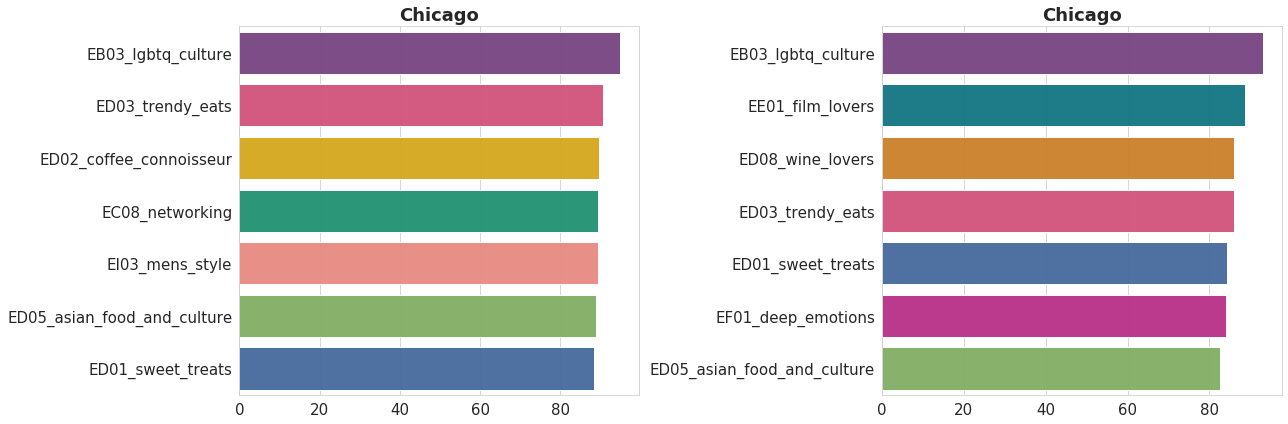

In [16]:
unique_segments = np.unique(top_ch_ret.head(7).index.tolist() + top_la_ret.head(7).index.tolist())
palette_c=['#7F3C8D','#11A579','#3969AC','#F2B701','#E73F74','#80BA5A','#E68310','#008695','#CF1C90','#f97b72', '#4b4b8f', '#A5AA99']
color_dict = dict(zip(unique_segments, palette_c))

def plot_top_segments(df, ax, color_dict):
    sns.barplot(x='50%', y='social_segment', data=df.head(7).reset_index().rename(columns={'index':'social_segment'}), 
                alpha=0.96, ax=ax, palette=palette(df.head(7).index.tolist(), color_dict))
    ax.set_title('Chicago', fontsize=18, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=15)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
plot_top_segments(top_ch_ret, axs[0], color_dict)
plot_top_segments(top_la_ret, axs[1], color_dict)
fig.tight_layout()

##### Characterization based on indices

<b>Main insights</b>:
- Both cities share 4 out of the 7 most impactful social indices: Breakfast+brunch, coffe, foodie, and high end affinity.
- In Chicago top eating places performers are located where late night, fashion, and entertainment affinity are high, whereas in LA they are located where politically liberal, personal care, and organic+local affinity are high.

In [17]:
social_indices_columns = ch_ret.columns[-22:-3]

top_ch_ret_ix = ch_ret[ch_ret[f'{target_var}_class'] == 'Top 5%']
top_ch_ret_ix = top_ch_ret_ix[social_indices_columns].describe().transpose()
top_ch_ret_ix.sort_values(['50%'], ascending=False, inplace=True)

top_la_ret_ix = la_ret[la_ret[f'{target_var}_class'] == 'Top 5%']
top_la_ret_ix = top_la_ret_ix[social_indices_columns].describe().transpose()
top_la_ret_ix.sort_values(['50%'], ascending=False, inplace=True)

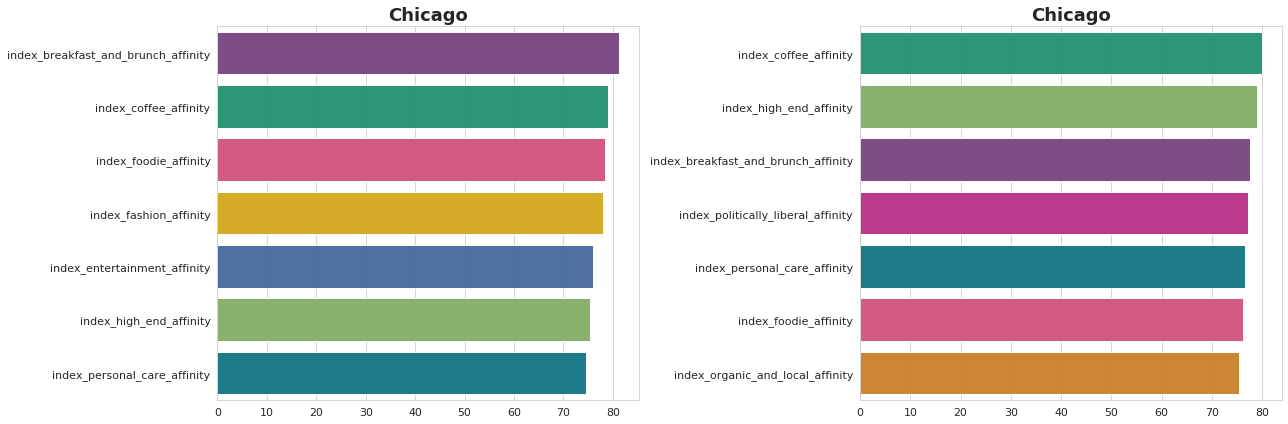

In [18]:
unique_segments = np.unique(top_ch_ret_ix.head(7).index.tolist() + top_la_ret_ix.head(7).index.tolist())
palette_c=['#7F3C8D','#11A579','#3969AC','#F2B701','#E73F74','#80BA5A','#E68310','#008695','#CF1C90','#f97b72']
color_dict = dict(zip(unique_segments, palette_c))

def plot_top_indices(df, ax, color_dict):
    sns.barplot(x='50%', y='index', data=df.head(7).reset_index(), 
                alpha=0.96, ax=ax, palette=palette(df.head(7).index.tolist(), color_dict))
    ax.set_title('Chicago', fontsize=18, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=11)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
plot_top_indices(top_ch_ret_ix, axs[0], color_dict)
plot_top_indices(top_la_ret_ix, axs[1], color_dict)
fig.tight_layout()

<a id='section23'></a>
#### 2.3 Correlation analysis

In this section we'll carry out a deeper analysis on how geosocial data can help explain retail performance. We'll compare the most important features for Chicago and LA.

##### Social segments

Here we calculate the correlation coefficient between every social segment and the total transaction amount for restaurants. This allows us to identify which segments have a strongest impact and the differences between both cities.

This analysis provides very interesting insights. We can see how the social segment _"sites to see"_ impacts positively in Chicago, while it barely impacts in LA.

In [19]:
def calculate_corrcoef(target_var, df, columns):
    corr_coefs = []
    for ssegment in columns:
        corr_aux = df[~df[ssegment].isnull()]
        corr_coefs.append(np.corrcoef(corr_aux[target_var], corr_aux[ssegment])[0][1])

    corr_df_ch = pd.DataFrame(data={'social_segment':columns, 'corr_coef':corr_coefs})
    corr_df_ch['corr_coef_abs'] = np.abs(corr_df_ch['corr_coef'])
    corr_df_ch.sort_values('corr_coef_abs', ascending=False, inplace=True)
    return corr_df_ch

In [20]:
corr_df_ch = calculate_corrcoef(target_var, ch_ret, social_segment_columns)
corr_df_la = calculate_corrcoef(target_var, la_ret, social_segment_columns)

corr_df_ch['city'] = 'Chicago'
corr_df_la['city'] = 'LA'
corr_df = pd.concat([corr_df_ch, corr_df_la], ignore_index=True)

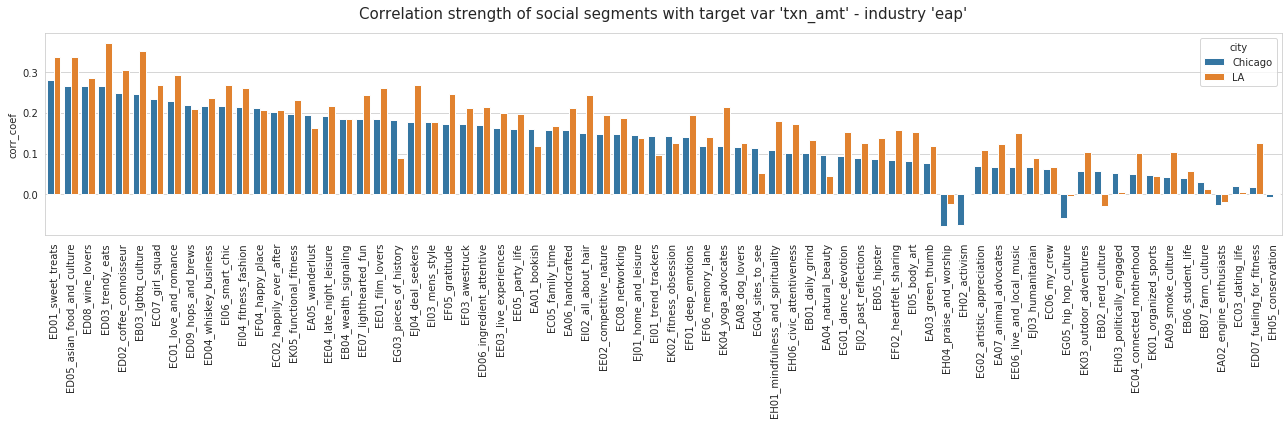

In [21]:
plt.figure(figsize=(18, 6))
sns.barplot(x='social_segment', y='corr_coef', hue='city', data=corr_df, alpha=0.99)
plt.xticks(rotation=90)
plt.xlabel('')
plt.title(f"Correlation strength of social segments with target var '{target_var}' - industry '{industry}'", 
          fontsize=15, fontweight='light', pad=15)
plt.tight_layout()

##### Indices

Now, we'll calculate the correlation coefficient between every social index and the metric total transaction amount for restaurants. This allows us to identify which indices have a strongest impact and the differences between both cities.

It is interesting to see the different correlation coefficients for older affinity and discount affinity in Chicago and LA.

In [22]:
corr_df_ch_ix = calculate_corrcoef(target_var, ch_ret, social_indices_columns)
corr_df_la_ix = calculate_corrcoef(target_var, la_ret, social_indices_columns)

corr_df_ch_ix['city'] = 'Chicago'
corr_df_la_ix['city'] = 'LA'
corr_df_ix = pd.concat([corr_df_ch_ix, corr_df_la_ix], ignore_index=True)

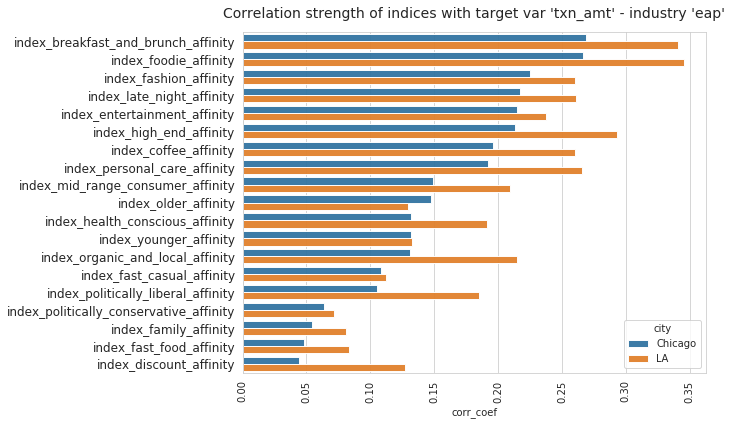

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(y='social_segment', x='corr_coef', hue='city', data=corr_df_ix, alpha=0.95)
plt.xticks(rotation=90)
plt.ylabel('')
plt.yticks(fontsize=12)
plt.title(f"Correlation strength of indices with target var '{target_var}' - industry '{industry}'", 
          fontsize=14, fontweight='light', pad=15)
plt.tight_layout()